# Example of visualising queries results

In [1]:
from io import BytesIO
import os
from PIL import Image
import pandas as pd
from datetime import datetime

from kentik_api import KentikAPI, SQLQuery
from kentik_api.public.query_object import (
    QueryObject,
    QueryArrayItem,
    Query,
    Aggregate,
    AggregateFunctionType,
    FastDataType,
    MetricType,
    DimensionType,
    ImageType,
    ChartViewType,
)

from applications_example import get_auth_email_token

## Preparations
### Getting connection credentials

In [2]:
email, token = get_auth_email_token()

### Instantiating Kentik API client

In [3]:
client = KentikAPI(email, token)

## Creating chart query
### Query specification

In [4]:
agg1 = Aggregate(name="avg_bits_per_sec", column="f_sum_both_bytes", fn=AggregateFunctionType.average, raw=True)
agg2 = Aggregate(name="p95th_bits_per_sec", column="f_sum_both_bytes", fn=AggregateFunctionType.percentile, rank=95)
agg3 = Aggregate(name="max_bits_per_sec", column="f_sum_both_bytes", fn=AggregateFunctionType.max)

In [5]:
query = Query(
    dimension=[DimensionType.Traffic],
    cidr=32,
    cidr6=128,
    metric=MetricType.bytes,
    topx=8,
    depth=75,
    fastData=FastDataType.auto,
    outsort="avg_bits_per_sec",
    overlay_day=-7,
    show_overlay=False,
    sync_axes=False,
    viz_type=ChartViewType.stackedArea,
    lookback_seconds=3600,
    hostname_lookup=True,
    device_name=[],
    matrixBy=[],
    all_selected=True,
    filters_obj=None,
    descriptor="",
    aggregates=[agg1, agg2, agg3],
)

### Wrapping query in QueryObject

In [6]:
query_item = QueryArrayItem(query=query, bucket="Left +Y Axis", isOverlay=False)
query_object = QueryObject(queries=[query_item], imageType=ImageType.png)

### Sending query for chart

In [7]:
result = client.query.chart(query_object)

### Creating Imege object from query result and displaying it

In [8]:
img = Image.open(BytesIO(result.get_data()))

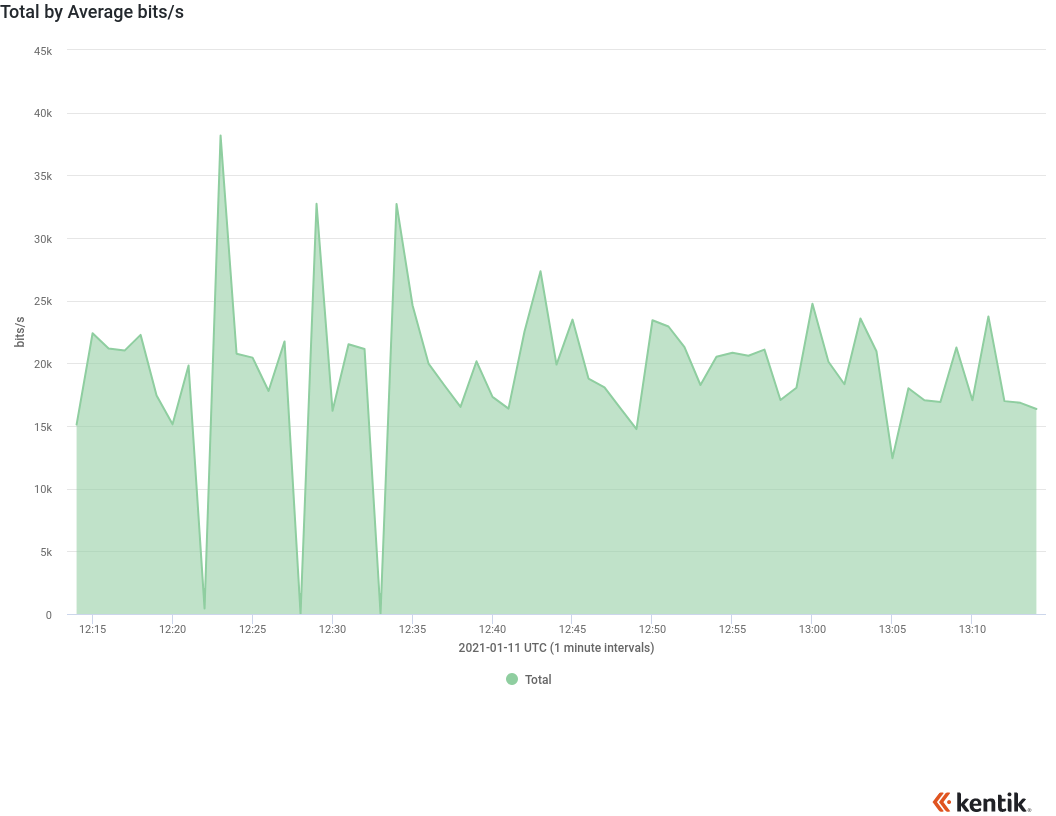

In [9]:
img

## Creating data query

### We will use the same query as in chart case

In [10]:
result2 = client.query.data(query_object)

### Creating pandas Dataframe from query result

In [11]:
columns = ["timestamp", "bits/s", "interval"]

In [12]:
df = pd.DataFrame(
    result2.results[0]["data"][0]["timeSeries"]["both_bits_per_sec"]["flow"],
    columns=columns
)

### Our timeseries in dataframe

In [13]:
df["Datetime"] = pd.to_datetime(df["timestamp"], unit="ms")
df = df.drop(columns=["timestamp", "interval"])
df

,bits/s,Datetime
0,15114.266667,2021-01-11 12:14:00
1,22399.466667,2021-01-11 12:15:00
2,21186.400000,2021-01-11 12:16:00
3,21016.666667,2021-01-11 12:17:00
4,22270.533333,2021-01-11 12:18:00
...,...,...
56,17058.933333,2021-01-11 13:10:00
57,23744.400000,2021-01-11 13:11:00
58,16984.933333,2021-01-11 13:12:00
59,16846.533333,2021-01-11 13:13:00


### Top 3 bits/s values in our time series data

In [14]:
df.sort_values(by=["bits/s"], ascending=False).head(3)

,bits/s,Datetime
9,38184.133333,2021-01-11 12:23:00
15,32731.466667,2021-01-11 12:29:00
20,32719.466667,2021-01-11 12:34:00
